In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../DropEdge/src'))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import time
import argparse
import numpy as np
import json

import torch
import torch.nn.functional as F
import torch.optim as optim
#from tensorboardX import SummaryWriter

from earlystopping import EarlyStopping
from sample import Sampler
from metric import accuracy, roc_auc_compute_fn
# from deepgcn.utils import load_data, accuracy
# from deepgcn.models import GCN

from metric import accuracy
from utils import load_citation, load_reddit_data
from models import *
from earlystopping import EarlyStopping
from sample import Sampler

In [5]:
from torch.nn import Module


class GraphConvolutionBSSVD(Module):
    def __init__(self, orig_layer, r=None):
        super(GraphConvolutionBSSVD, self).__init__()
        
        if r == None:
            r = min(orig_layer.in_features, orig_layer.out_features)
            
        self.r = r
        
        self.in_features = orig_layer.in_features
        self.out_features = orig_layer.out_features
        self.sigma = orig_layer.sigma
        
        U, s, V = torch.svd(orig_layer.weight)
        
        self.U = nn.Parameter(U)
        self.s = nn.Parameter(s)
        self.Vt = nn.Parameter(V.T)
        
        if orig_layer.bias is not None:
            self.bias = Parameter(orig_layer.bias)
        else:
            self.register_parameter('bias', None)


    def forward(self, input, adj):
        support = torch.mm(input, self.U[:, :self.r])
        support = support * self.s[:self.r]
        support = torch.mm(support, self.Vt[:self.r, :])
        output = torch.spmm(adj, support)
        
        if self.bias is not None:
            output = output + self.bias
        
        return self.sigma(output)

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) \
               + ', ' + str(self.r) + ')'
    
    def set_rank(self, r=None):
        if r is None:
            self.r = self.get_max_rank()
        else:
            self.r = r
        
    def get_max_rank(self):
        return len(self.s)

In [6]:
import copy

def make_new_model(model):
    n_layers = len(model.midlayer[0].model.hiddenlayers)
    new_model = copy.deepcopy(model)
    
    new_model.ingc = GraphConvolutionBSSVD(base_model.ingc)
    for i in range(n_layers):
        new_model.midlayer[0].model.hiddenlayers[i] = \
            GraphConvolutionBSSVD(base_model.midlayer[0].model.hiddenlayers[i])
    new_model.outgc = GraphConvolutionBSSVD(base_model.outgc)
    new_model.to(device)
    return new_model

def reset_rank(model):
    model.ingc.set_rank()
    for idx_layer in range(args['nbaseblocklayer']):
        model.midlayer[0].model.hiddenlayers[idx_layer].set_rank()

def test_model(model, test_adj, test_fea):
    model.eval()
    output = model(test_fea, test_adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    return loss_test.item(), acc_test.item()

In [7]:
nbaseblocklayer = 9

In [8]:
import subprocess
import pickle as pkl
from collections import defaultdict
from tqdm.notebook import tqdm
# 
# 
# for nbaseblocklayer in tqdm(range(3, 10)):
#     result = {}
#     for seed in tqdm(range(100)):
#         script = "python ../DropEdge/src/train_new.py \
#         --debug \
#         --seed {1} \
#         --datapath ../DropEdge/data// \
#         --dataset cora \
#         --type mutigcn \
#         --nhiddenlayer 1 \
#         --nbaseblocklayer {0} \
#         --hidden 128 \
#         --epoch 400 \
#         --lr 0.01 \
#         --weight_decay 0.005 \
#         --early_stopping 400 \
#         --sampling_percent 1 \
#         --dropout 0.8 \
#         --normalization FirstOrderGCN \
#         --path_save 'tmpmodel/cora_gcn_{0}blocks.pt' \
#         --args_save 'tmpmodel/cora_gcn_{0}blocks.json'".format(nbaseblocklayer, seed)
#         process = subprocess.Popen(script, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
#         output = process.communicate()[0]
#         exitCode = process.returncode
#         
#         if exitCode != 0:
#             continue
#     
#         with open('tmpmodel/cora_gcn_{0}blocks.json'.format(nbaseblocklayer), 'r') as f:
#             args = json.load(f)
#         
#         sampler = Sampler(args['dataset'], '../DropEdge/data/', args['task_type'], args['cuda_device'])
#         labels, idx_train, idx_val, idx_test = sampler.get_label_and_idxes(args['cuda'])
#         nfeat = sampler.nfeat
#         nclass = sampler.nclass
#         
#         device = 'cuda:1'
#         base_model = GCNModel(nfeat=nfeat,
#                               nhid=args['hidden'],
#                               nclass=nclass,
#                               nhidlayer=args['nhiddenlayer'],
#                               dropout=args['dropout'],
#                               baseblock=args['type'],
#                               inputlayer=args['inputlayer'],
#                               outputlayer=args['outputlayer'],
#                               nbaselayer=args['nbaseblocklayer'],
#                               activation=F.relu,
#                               withbn=args['withbn'],
#                               withloop=args['withloop'],
#                               aggrmethod=args['aggrmethod'],
#                               mixmode=args['mixmode']
#                              )
#         base_model.load_state_dict(torch.load(
#             'tmpmodel/cora_gcn_{0}blocks.pt'.format(nbaseblocklayer)))
#         base_model.eval()
#         base_model.to(device)
#         
#         new_model = make_new_model(base_model)
#         new_model.eval()
#         
#         singular_values = {}
#         singular_values['input'] = new_model.ingc.s.cpu().detach().numpy()
#         for i in range(args['nbaseblocklayer']):
#             singular_values[str(i)] = new_model.midlayer[0].model.hiddenlayers[i].s.cpu().detach().numpy()
#         
#         (test_adj, test_fea) = sampler.get_test_set(
#             normalization=args['normalization'],
#             cuda=args['cuda']
#         ) 
#         
#         losses = defaultdict(list)
#         accs = defaultdict(list)
#         
#         for r in range(1, new_model.ingc.get_max_rank() + 1):
#             new_model.ingc.set_rank(r)
#             loss, acc = test_model(new_model, test_adj, test_fea)
#             losses['input'].append(loss)
#             accs['input'].append(acc)
#         new_model.ingc.set_rank()
#         
#         for idx_layer in range(args['nbaseblocklayer']):
#             for r in range(1, new_model.midlayer[0].model.hiddenlayers[idx_layer].get_max_rank() + 1):
#                 new_model.midlayer[0].model.hiddenlayers[idx_layer].set_rank(r)
#                 loss, acc = test_model(new_model, test_adj, test_fea)
#                 losses[str(idx_layer)].append(loss)
#                 accs[str(idx_layer)].append(acc)
#             new_model.midlayer[0].model.hiddenlayers[idx_layer].set_rank()
#         
#         result[seed] = {
#             'singular_values': singular_values,
#             'losses': losses,
#             'accs': accs
#         }
#         
#         with open('results/result{0}.pkl'.format(nbaseblocklayer), 'wb') as f:
#             pkl.dump(result, f)

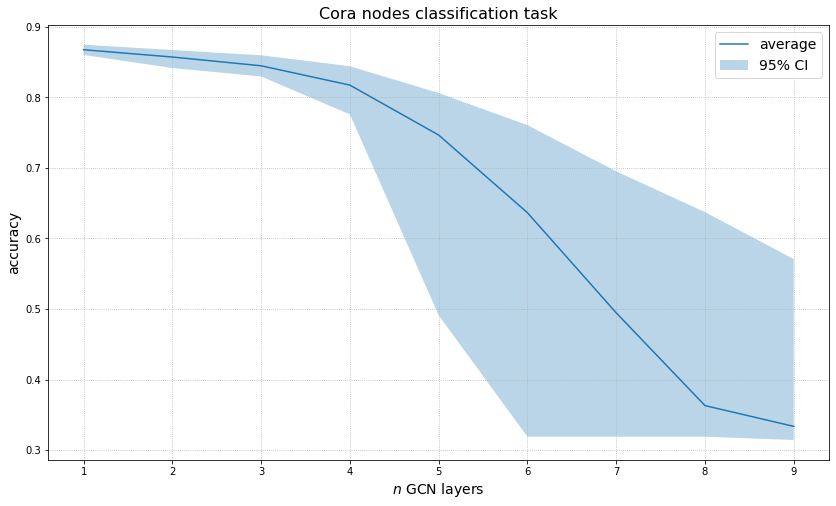

In [33]:
accs = []
for nbaseblocklayer in range(1, 10):
    with open('results/result{0}.pkl'.format(nbaseblocklayer), 'rb') as f:
        result = pkl.load(f)
    accs_n = []
    for seed in result:
        accs_n.append(result[seed]['accs']['input'][-1])
    accs.append(accs_n)
accs = np.array(accs)

plt.figure(figsize=(14, 8))
plt.plot(range(1, 10), accs.mean(axis=1), label='average')
plt.fill_between(range(1, 10),
                 np.percentile(accs, 2.5, axis=1),
                 np.percentile(accs, 97.5, axis=1),
                 alpha=0.3, label='95% CI')
plt.xlabel('$n$ GCN layers', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.title('Cora nodes classification task', fontsize=16)
plt.legend(fontsize=14)
plt.grid(ls=":")
plt.show()

In [10]:
result_draw = {}
seeds = list(result.keys())
example = result[seeds[0]]
for metric_type in example:
    result_draw[metric_type] = {}
    for layer_type in example[metric_type]:
        result_draw[metric_type][layer_type] = {}
        for seed in seeds:
            result_draw[metric_type][layer_type][seed] = result[seed][metric_type][layer_type]

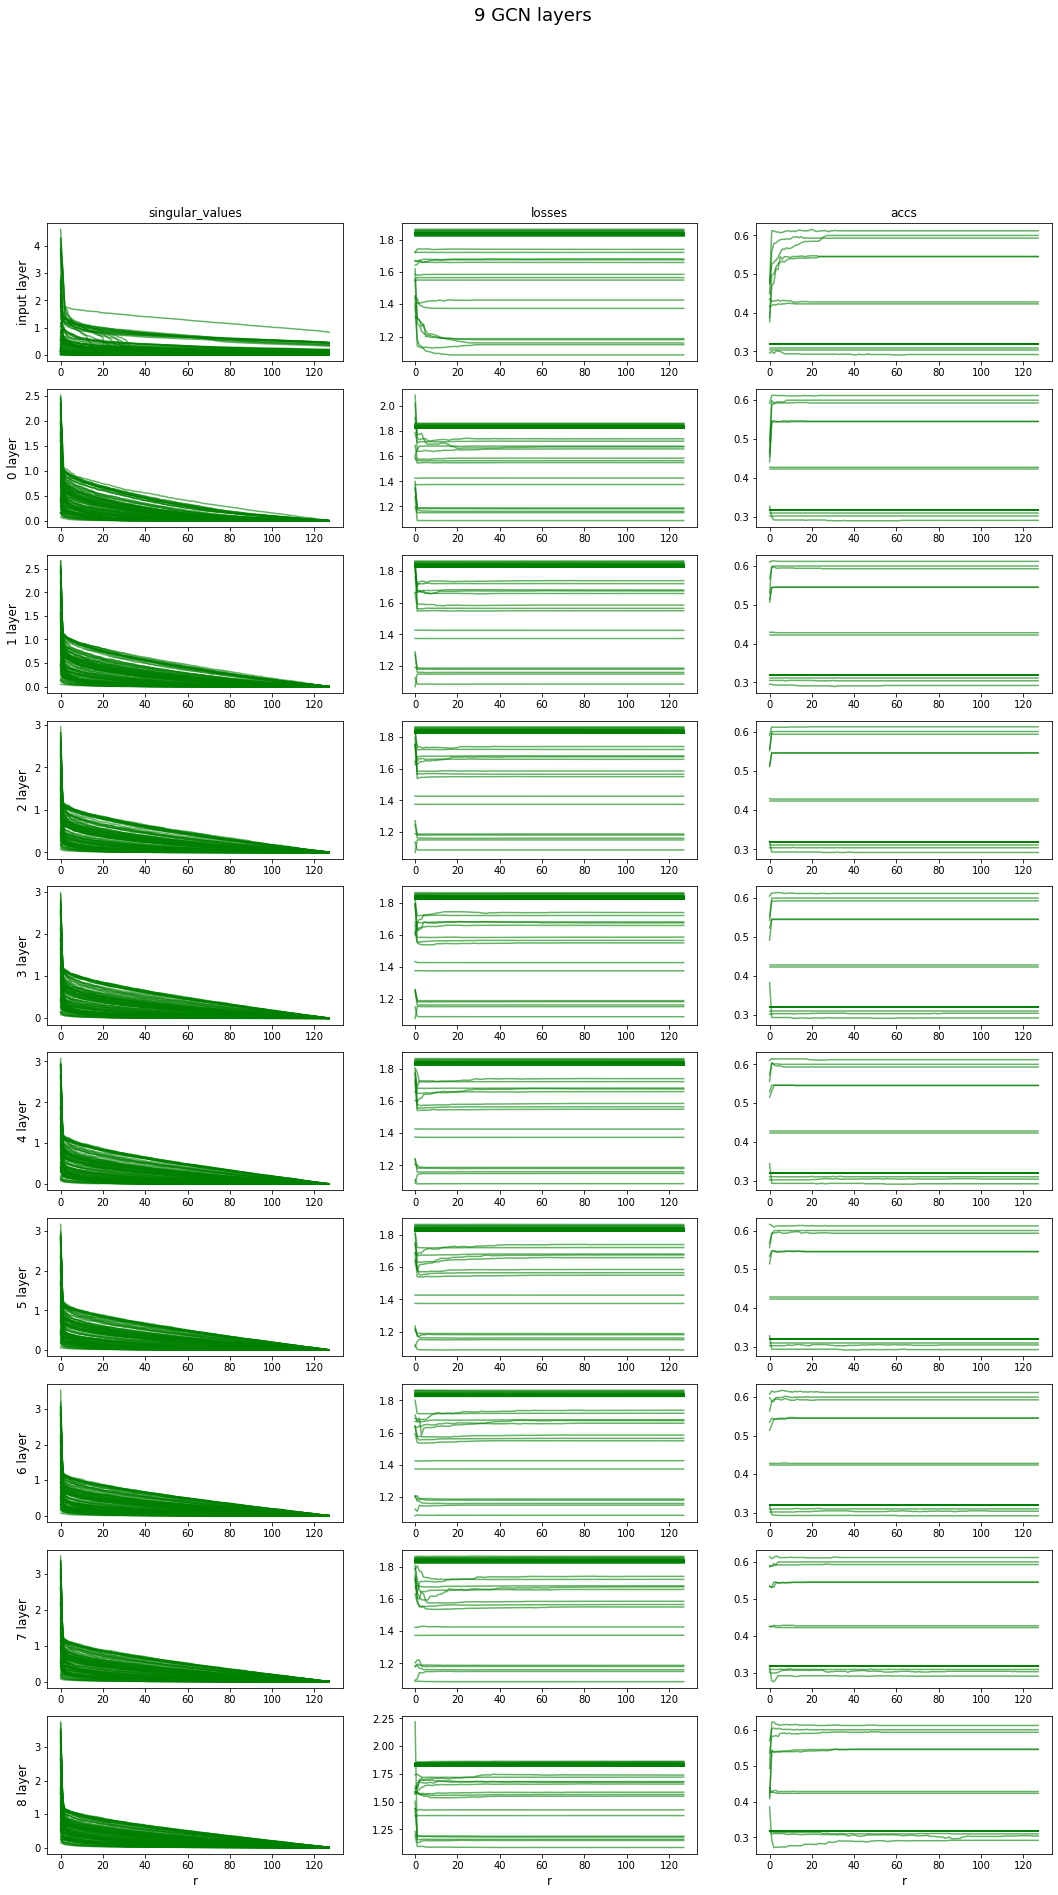

In [11]:
n_metrics = len(result_draw)
n_layers = len(result_draw['accs'])
plt.figure(figsize=(n_metrics * 6, n_layers * 3))
plt.suptitle('{} GCN layers'.format(nbaseblocklayer), fontsize=18)
for idx_m, metric_type in enumerate(result_draw):
    for idx_l, layer_type in enumerate(result_draw[metric_type]):
        plt.subplot(n_layers, n_metrics, idx_l * n_metrics + idx_m + 1)
        
        stats = np.array(list(result_draw[metric_type][layer_type].values())).T
        for i in range(stats.shape[1]):
            plt.plot(stats[:, i], color='green', alpha=0.6)
        
        if idx_l == 0:
            plt.title(metric_type, fontsize=12)
            
        if idx_l == n_layers - 1:
            plt.xlabel('r', fontsize=12)
            
        # if metric_type == 'losses':
        #     plt.ylim(0.8, 1.7)
        # 
        # if metric_type == 'accs':
        #     plt.ylim(0.45, 0.74)
        
        if idx_m == 0:
            plt.ylabel(layer_type + ' layer', fontsize=12)

plt.show()